<a href="https://colab.research.google.com/github/AnnieCRY/DS5230-project/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### load in processed data from previous step

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# move zip file to colab vm
! cp -r gdrive/My\ Drive/5230Project/processed_data ./

In [3]:
# download the supporting files from github
! rm -rf Audio_based_identification_beehive_states/
! git clone https://github.com/Tonyz4516/Audio_based_identification_beehive_states.git

Cloning into 'Audio_based_identification_beehive_states'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 118 (delta 0), reused 0 (delta 0), pack-reused 114
Receiving objects: 100% (118/118), 69.02 KiB | 4.06 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [4]:
! mv Audio_based_identification_beehive_states/Bee_NotBee_classification/* ./


# PCA & TSNE

In [ ]:
! pip install muda

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from info import i, printb, printr, printp, print
from utils import load_audioFiles_saves_segments, write_Statelabels_from_beeNotBeelabels, get_uniqueHives_names_from_File, split_samples_byHive, get_samples_id_perSet, get_features_from_samples, get_GT_labels_fromFiles, labels2binary


In [8]:
block_size = 5
path_workingFolder = '/content/processed_data/dataset_BeeNoBee_'+str(block_size)+'sec'+os.sep  # path where to save audio segments and labels files.
labels2read = 'labels_BeeNotBee_th0'
feature = 'MFCCs20'

In [9]:
# Feature extraction: 
# remember to un-comment the 3 lines about normalization in utils.get_features_from_samples
sample_ids_test, sample_ids_train, sample_ids_val = get_samples_id_perSet(path_workingFolder+'split_random_0.json') 
    
X_train = get_features_from_samples(path_workingFolder, sample_ids_train, 'MFCCs20', 'NO', 1)
X_val = get_features_from_samples(path_workingFolder, sample_ids_val, 'MFCCs20', 'NO', 1)
X_test = get_features_from_samples(path_workingFolder, sample_ids_test, 'MFCCs20', 'NO', 1)
    
    
labels_train = get_GT_labels_fromFiles(path_workingFolder, sample_ids_train, labels2read)
Y_train= labels2binary('nobee', labels_train)
    
labels_val = get_GT_labels_fromFiles(path_workingFolder, sample_ids_val, labels2read)
Y_val= labels2binary('nobee', labels_val)
    
labels_test = get_GT_labels_fromFiles(path_workingFolder, sample_ids_test, labels2read)
Y_test= labels2binary('nobee', labels_test)

In [10]:
# 2-component PCA:
pca = PCA(n_components = 2)

pca = PCA(n_components = 2).fit_transform(X_train)

pca_df = pd.DataFrame(data = pca, columns = ['component1', 'component2'])

pca_df = pd.concat([pca_df, pd.DataFrame(Y_train, columns = ['label'])], axis = 1)

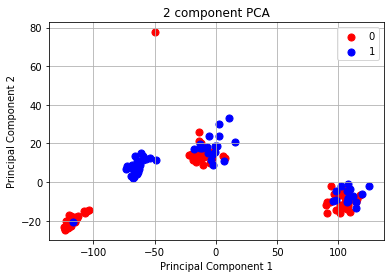

In [12]:
# 2-component PCA visualization:
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2 component PCA')
labels = [0, 1]
colors = ['r', 'b']
for label, color in zip(labels, colors):
    indicesToKeep = pca_df['label'] == label
    ax.scatter(pca_df.loc[indicesToKeep, 'component1']
               , pca_df.loc[indicesToKeep, 'component2']
               , c = color
               , s = 50)
ax.grid()
ax.legend(labels)
plt.show()

In [13]:
# 3-component PCA:
pca3 = PCA(n_components = 3)

pca3 = PCA(n_components = 3).fit_transform(X_train)

pca3_df = pd.DataFrame(data = pca3, columns = ['component1', 'component2', 'component3'])

pca3_df = pd.concat([pca3_df, pd.DataFrame(Y_train, columns = ['label'])], axis = 1)

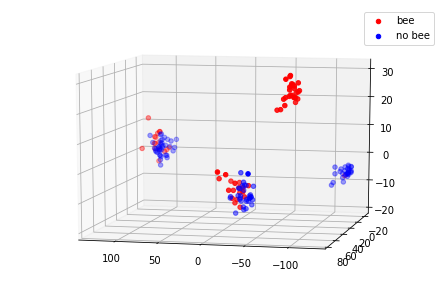

In [14]:
# 3-component PCA visualization:
pca3_bee = pca3_df[pca3_df.label == 1]

pca3_nobee = pca3_df[pca3_df.label == 0]

x1 = pca3_bee.component1
y1 = pca3_bee.component2
z1 = pca3_bee.component3

x2 = pca3_nobee.component1
y2 = pca3_nobee.component2
z2 = pca3_nobee.component3

fig3 = plt.figure()
ax = Axes3D(fig3)

ax.scatter(x1, y1, z1, c = 'r', label = 'bee')
ax.scatter(x2, y2, z2, c = 'b', label = 'no bee')
ax.legend(loc = 'best')
ax.view_init(elev = 10, azim = 103)
#for ii in range(0,360):
#    ax.view_init(elev=10., azim=ii)
#    plt.savefig("D:\\3Dplot\\movie%d.png" % ii)

plt.show()

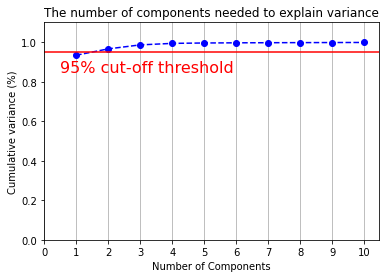

In [15]:
# get optimal number of components for PCA
pca = PCA().fit(X_train)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_[0:10])

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [16]:
# TSNE:
tsne = TSNE(n_components=2).fit_transform(X_train)

tsne_df = pd.DataFrame(data = tsne, columns = ['component1', 'component2'])

tsne_df = pd.concat([tsne_df, pd.DataFrame(Y_train, columns = ['label'])], axis = 1)

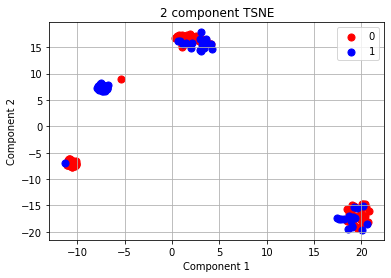

In [17]:
# TSNE visualization
fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1) 
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_title('2 component TSNE')
for label, color in zip(labels, colors):
    indicesToKeep = tsne_df['label'] == label
    ax2.scatter(tsne_df.loc[indicesToKeep, 'component1']
               , tsne_df.loc[indicesToKeep, 'component2']
               , c = color
               , s = 50)
ax2.grid()
ax2.legend(labels)
plt.show()
